In [25]:
import torch
import torch.nn as nn
import numpy as np
import csv
from datetime import datetime as dt
import matplotlib.pyplot as plt

In [26]:
class Model(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.rnn = nn.LSTM(input_size=3, hidden_size=128, num_layers=2, bias=False, batch_first=True)
        self.linear1 = nn.Linear(128, 64, bias=True)
        self.linear2 = nn.Linear(64, 1, bias=True)
        self.norm = nn.Sigmoid()

    def forward(self, x):
        x = self.rnn(x)[0][:,-1,:]
        x = self.linear1(x)
        x = self.linear2(x)
        out = self.norm(x)
        return out

model = Model()
model.load_state_dict(torch.load('models/1700_model.pt'))
model.eval()

Model(
  (rnn): LSTM(3, 128, num_layers=2, bias=False, batch_first=True)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
  (norm): Sigmoid()
)

In [27]:
def load_csv(file):
    datetime = []
    temp = []
    humd = []
    power = []
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            d, t, h, p = row
            d = dt.fromisoformat(d)
            d = d.hour + d.minute / 60
            datetime.append(d)
            temp.append(float(t))
            humd.append(float(h))
            power.append(float(p))
    return (datetime, temp, humd, power)


file = "zuraach_ail2/2023-07-07_raw.csv"
date, temp, humd, power = load_csv(file)

dn = np.array(date) / 24
tn = np.array(temp)
tn /= 33.01
hn = np.array(humd)
hn /= 52.58
pn = np.array(power) / 1.8

dn_list = dn.tolist()
tn_list = tn.tolist()
hn_list = hn.tolist()
pn_list = pn.tolist()

In [28]:
WINDOW = 7

preds = []
labels = []
pred_date = []

for i in range(len(dn_list) - (WINDOW - 1)):
    data = []
    data.append(dn_list[i:i+WINDOW])
    data.append(tn_list[i:i+WINDOW])
    data.append(hn_list[i:i+WINDOW])
    data_T = np.array(data).T

    if pn_list[i:i+WINDOW][0] >= 0.6:
        labels.append(1)
    else:
        labels.append(0)

    data_tensor = torch.tensor(data_T).float().unsqueeze(0)

    with torch.no_grad():
        out = model(data_tensor)[0]
    preds.append(out.item())
    pred_date.append(np.mean(date[i:i+WINDOW]))

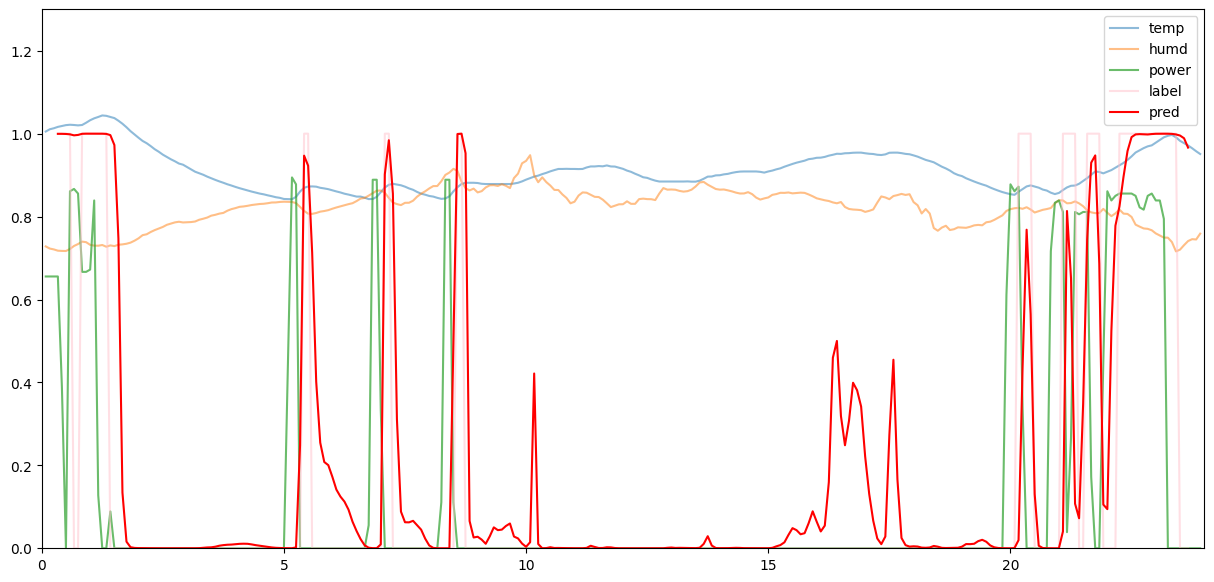

In [29]:
plt.figure(figsize=[15, 7])
plt.axis([0, 24, 0, 1.3])
plt.plot(date, tn, alpha=0.5, label='temp')
plt.plot(date, hn, alpha=0.5, label='humd')
plt.plot(date, pn, alpha=0.7, label='power')
plt.plot(pred_date, labels, alpha=0.5, label='label', c='pink')
plt.plot(pred_date, preds, alpha=1, label='pred', c='r')
plt.legend()